In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import time
from multiprocessing import Pool
from pathlib import Path
import pathlib, pickle

from sklearn.metrics import f1_score, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt


import sys, os
# add folder path where discrepancies folder is
#_PATH = '/Users/a435vv/OneDrive - AXA/Projects/BlackboxesDiscrepancies/discrepancies-in-machine-learning/'
#sys.path.insert(0, _PATH) 
sys.path.append(os.path.dirname(sys.path[0]))

from discrepancies import datasets, pool, pool2graph, evaluation

In [72]:
_DATASET = 'boston'
_K_INIT = 100
_K_REFINEMENT = 0
_MAX_EPOCHS = 10

X_train, X_test, y_train, y_test, scaler, feature_names, target_names = datasets.get_dataset(dataset=_DATASET, n_samples=1000, noise=0.3)

pool1 = pool.AutoSklearnPool(max_delta_accuracies=0.05, time_left_for_this_task=30, n_jobs=14)
pool1 = pool1.fit(X_train, y_train)

p2g = pool2graph.pool2graph(X_train,
                            y_train,
                            pool1,
                            k_init=_K_INIT,
                            k_refinement=_K_REFINEMENT)

p2g.fit(max_epochs=_MAX_EPOCHS)

In [15]:
from yellowbrick.classifier import PrecisionRecallCurve, ClassificationReport

def plot_PRC(model, X_train, y_train, X_test, y_test):
    # Create the visualizer, fit, score, and show it
    viz = ClassificationReport(model)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()

ModuleNotFoundError: No module named 'yellowbrick'

In [73]:
#X_mc, kde_score = evaluation.random_sampling_kde(X_train, n=20000)
#X_mc = pd.DataFrame(X_mc, columns=X_train.columns)
#y_mc_pool_discr = p2g.pool.predict_discrepancies(X_mc)


X_mc = np.random.uniform(low=X_train.min(), high=X_train.max(), size=(100000,X_train.shape[1]))
y_mc_pool_discr = p2g.pool.predict_discrepancies(X_mc)

In [74]:
X_mc = pd.DataFrame(X_mc, columns=X_train.columns)

<AxesSubplot:>

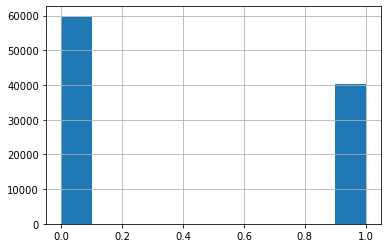

In [75]:
y_mc_pool_discr.hist()

In [76]:
components = p2g.get_discrepancies_components()

In [77]:
components.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [78]:
components.nunique()

934

In [79]:
components.shape

(4666,)

In [80]:
components[components==1].shape

(1698,)

<AxesSubplot:>

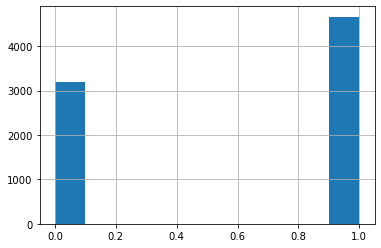

In [81]:
X_discr, y_discr = p2g.get_discrepancies_dataset()
X_discr.shape
y_discr.hist()

<AxesSubplot:>

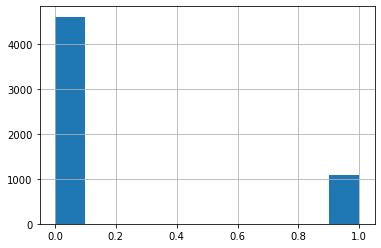

In [82]:
X_samples.shape
y_samples_pool_discr.hist()

In [83]:
X_discr, y_discr = p2g.get_discrepancies_dataset()

xgbc_p2g = xgb.XGBClassifier(n_jobs=1, verbosity=0).fit(X_discr, y_discr)
tmp = f1_score(y_mc_pool_discr, xgbc_p2g.predict(X_mc))
print(tmp)

####

X_samples, kde_score = evaluation.random_sampling_kde(X_train, n=len(X_discr))
X_samples = pd.DataFrame(X_samples, columns=X_train.columns)
y_samples_pool_discr = p2g.pool.predict_discrepancies(X_samples)

xgbc_rs = xgb.XGBClassifier(n_jobs=1, verbosity=0).fit(X_samples, y_samples_pool_discr)
tmp = f1_score(y_mc_pool_discr, xgbc_rs.predict(X_mc))
print(tmp)

0.4242058562555457
0.6237462471559163


In [55]:
X_discr_sub = X_discr.sample(frac=0.95)
tmp = X_samples[y_samples_pool_discr==0].sample(n=X_discr.shape[0]-X_discr_sub.shape[0])
X_tmp = pd.concat((X_discr_sub,tmp), axis=0)

tmp = y_samples_pool_discr.iloc[tmp.index]
y_tmp = pd.concat((y_discr.loc[X_discr_sub.index],tmp), axis=0)

xgbc_p2g_imp = xgb.XGBClassifier(n_jobs=1, verbosity=0).fit(X_tmp, y_tmp)
tmp = f1_score(y_mc_pool_discr, xgbc_p2g_imp.predict(X_mc))
print(tmp)

0.40285204991087337


In [13]:
plot_PRC(xgbc_p2g, X_samples, y_discr, X_mc, y_mc_pool_discr)
plot_PRC(xgbc_p2g_imp, X_tmp, y_tmp, X_mc, y_mc_pool_discr)
plot_PRC(xgbc_rs, X_discr, y_samples_pool_discr, X_mc, y_mc_pool_discr)

NameError: name 'plot_PRC' is not defined

<AxesSubplot:>

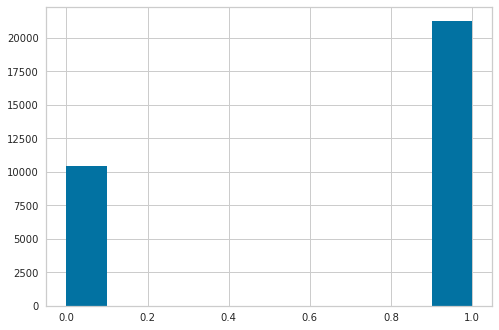

In [43]:
y_discr.hist()

<AxesSubplot:>

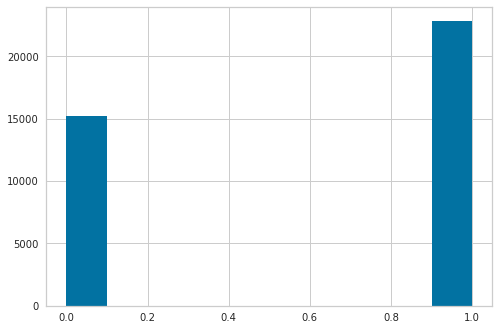

In [44]:
y_tmp.hist()

<AxesSubplot:>

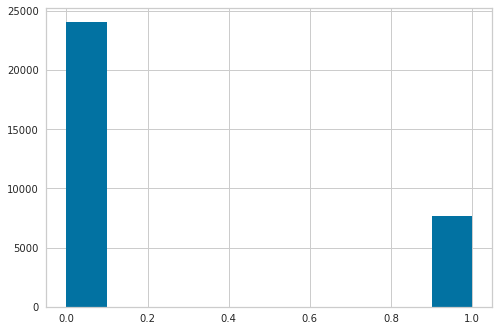

In [45]:
y_samples_pool_discr.hist()

In [3]:
_DATASET = 'half-moons'

X_train, X_test, y_train, y_test, scaler, feature_names, target_names = datasets.get_dataset(dataset=_DATASET, n_samples=1000, noise=0.3)

pool1 = pool.AutoSklearnPool(max_delta_accuracies=0.05, time_left_for_this_task=30, n_jobs=14)
pool1 = pool1.fit(X_train, y_train)


In [40]:
lowerbound_accuracy = np.max(pool1.automl.cv_results_['mean_test_score'])*(1-pool1.max_delta_accuracies)
accuracies = pool1.automl.cv_results_['mean_test_score']
models_2_pool = accuracies>=lowerbound_accuracy

In [45]:
accuracies[models_2_pool]

array([0.87387387, 0.87837838, 0.88288288, 0.88738739])

In [35]:
def plot_comparison(_K_INIT=10, _K_REFINEMENT=0, _MAX_EPOCHS=10):
    
    p2g = pool2graph.pool2graph(X_train,
                            y_train,
                            pool1,
                            k_init=_K_INIT,
                            k_refinement=_K_REFINEMENT)
    p2g.fit(max_epochs=_MAX_EPOCHS)
    X_discr, y_discr = p2g.get_discrepancies_dataset()
    
    X_samples, kde_score = evaluation.random_sampling_kde(X_train, n=len(X_discr))
    X_samples = pd.DataFrame(X_samples, columns=X_train.columns)
    y_samples_pool_discr = p2g.pool.predict_discrepancies(X_samples)

    fig, axs = plt.subplots(1,2, figsize=(8,3))
    
    X_discr[y_discr==0].plot(kind='scatter', x=0, y=1, ax=axs[0])
    X_discr[y_discr==1].plot(kind='scatter', x=0, y=1, ax=axs[0], c='r')
    axs[0].title.set_text('P2G')
    
    X_samples[y_samples_pool_discr==0].plot(kind='scatter', x=0, y=1, ax=axs[1])
    X_samples[y_samples_pool_discr==1].plot(kind='scatter', x=0, y=1, ax=axs[1], c='r')
    axs[1].title.set_text('KDE')
    
    plt.suptitle(str(len(X_discr))+' points')

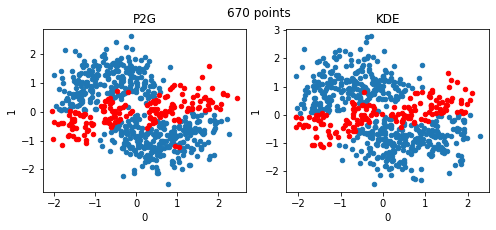

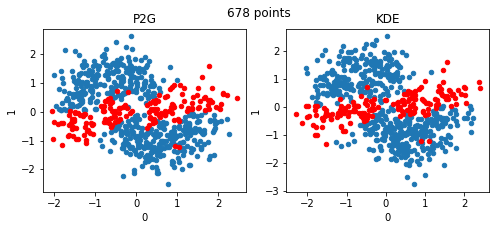

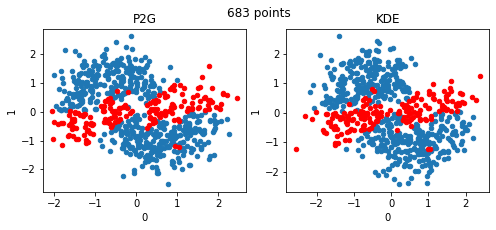

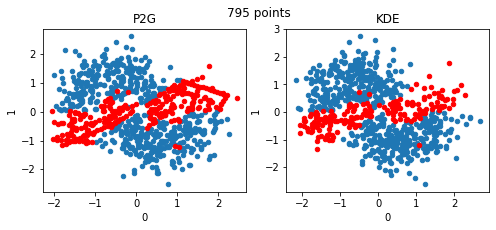

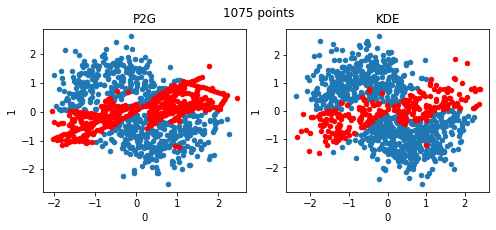

In [52]:
plot_comparison(_K_INIT=2, _K_REFINEMENT=0, _MAX_EPOCHS=0)
plot_comparison(_K_INIT=2, _K_REFINEMENT=0, _MAX_EPOCHS=1)
plot_comparison(_K_INIT=2, _K_REFINEMENT=0, _MAX_EPOCHS=2)
plot_comparison(_K_INIT=2, _K_REFINEMENT=0, _MAX_EPOCHS=5)
plot_comparison(_K_INIT=2, _K_REFINEMENT=0, _MAX_EPOCHS=10)

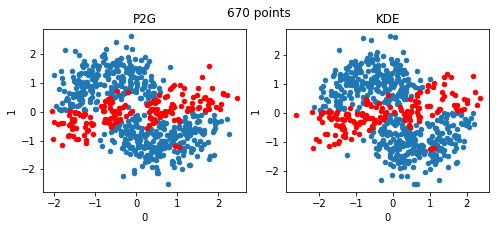

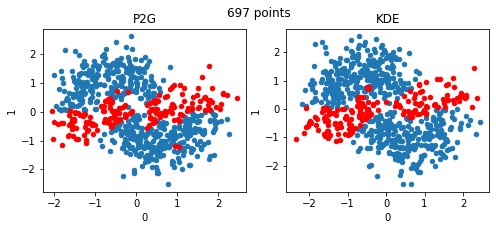

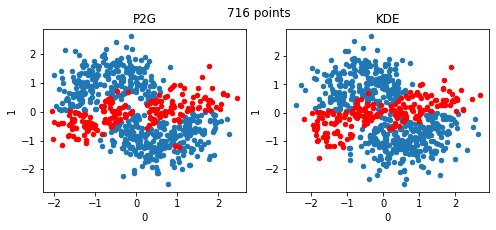

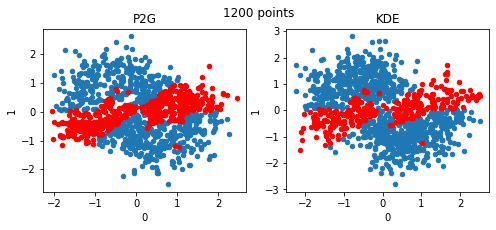

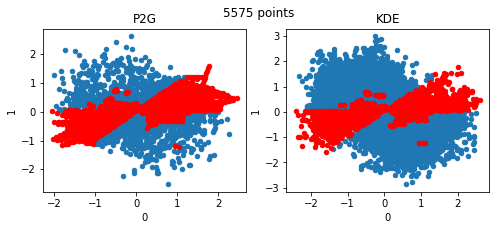

In [36]:
plot_comparison(_K_INIT=10, _K_REFINEMENT=0, _MAX_EPOCHS=0)
plot_comparison(_K_INIT=10, _K_REFINEMENT=0, _MAX_EPOCHS=1)
plot_comparison(_K_INIT=10, _K_REFINEMENT=0, _MAX_EPOCHS=2)
plot_comparison(_K_INIT=10, _K_REFINEMENT=0, _MAX_EPOCHS=5)
plot_comparison(_K_INIT=10, _K_REFINEMENT=0, _MAX_EPOCHS=10)

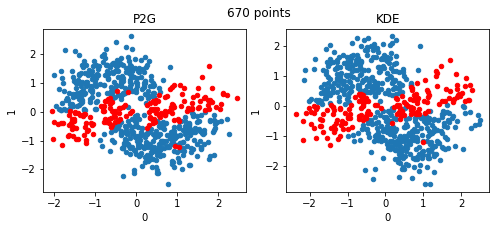

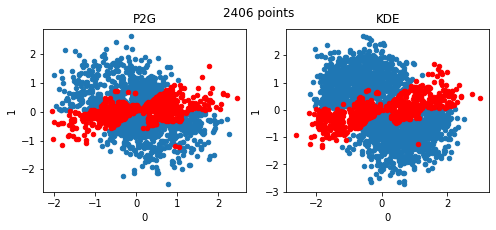

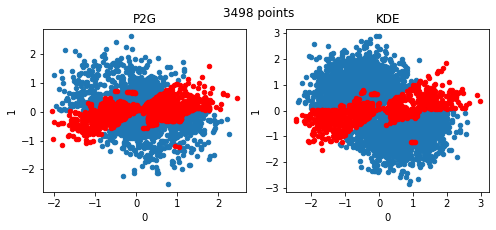

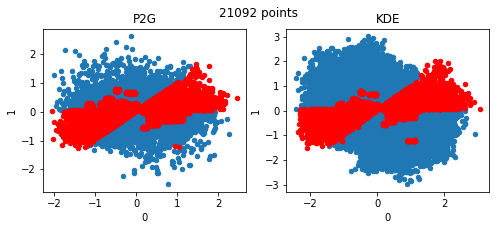

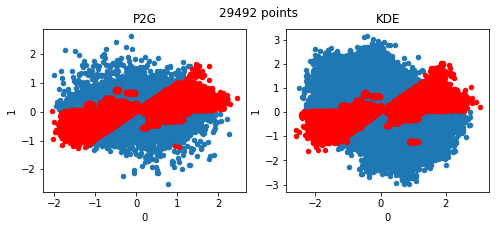

In [37]:
plot_comparison(_K_INIT=100, _K_REFINEMENT=0, _MAX_EPOCHS=0)
plot_comparison(_K_INIT=100, _K_REFINEMENT=0, _MAX_EPOCHS=1)
plot_comparison(_K_INIT=100, _K_REFINEMENT=0, _MAX_EPOCHS=2)
plot_comparison(_K_INIT=100, _K_REFINEMENT=0, _MAX_EPOCHS=5)
plot_comparison(_K_INIT=100, _K_REFINEMENT=0, _MAX_EPOCHS=10)

In [3]:
_DATASET = 'boston'
_K_INIT = 10
_K_REFINEMENT = 0
_MAX_EPOCHS = 3

X_train, X_test, y_train, y_test, scaler, feature_names, target_names = datasets.get_dataset(dataset=_DATASET, n_samples=1000, noise=0.3)
pool1 = pool.AutoSklearnPool(max_delta_accuracies=0.05, time_left_for_this_task=30, n_jobs=14)
pool1 = pool1.fit(X_train, y_train)

In [4]:
X_samples, kde_score = evaluation.random_sampling_kde(X_train, n=10000)
X_samples = pd.DataFrame(X_samples, columns=X_train.columns)
y_samples = pool1.predict(X_samples).iloc[:,0]

In [5]:
p2g = pool2graph.pool2graph(X_samples,
                            y_samples,
                            pool1,
                            k_init=_K_INIT,
                            k_refinement=_K_REFINEMENT)

p2g.fit(max_epochs=2)

In [10]:
tmp = p2g.get_discrepancies_components()

In [14]:
tmp.value_counts()

1      16330
2       3559
3       1015
4        640
5        612
       ...  
455        1
439        1
774        1
758        1
783        1
Name: cluster, Length: 786, dtype: int64

In [6]:
X_mc = np.random.uniform(low=X_train.min(), high=X_train.max(), size=(20000,X_train.shape[1]))
y_mc_pool_discr = p2g.pool.predict_discrepancies(X_mc)

X_mc = pd.DataFrame(X_mc, columns=X_train.columns)

In [7]:
X_discr, y_discr = p2g.get_discrepancies_dataset()

xgbc_p2g = xgb.XGBClassifier(n_jobs=1, verbosity=0).fit(X_discr, y_discr)
tmp = f1_score(y_mc_pool_discr, xgbc_p2g.predict(X_mc))
print(tmp)

####

X_samples, kde_score = evaluation.random_sampling_kde(X_train, n=len(X_discr))
X_samples = pd.DataFrame(X_samples, columns=X_train.columns)
y_samples_pool_discr = p2g.pool.predict_discrepancies(X_samples)

xgbc_rs = xgb.XGBClassifier(n_jobs=1, verbosity=0).fit(X_samples, y_samples_pool_discr)
tmp = f1_score(y_mc_pool_discr, xgbc_rs.predict(X_mc))
print(tmp)

0.3919554985023535
0.5474225889450802
